In [1]:
import os
import torch
import mae.models_mae
from mae.models_mae import MaskedAutoencoderViT
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from pathlib import Path

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(os.getcwd())

/workspace/gfm-gap-filling/pretraining


In [3]:
from mae_training import CombinedDataset

In [4]:
local_rank = 1
mean = torch.tensor([495.7316,  814.1386,  924.5740, 2962.5623, 2640.8833, 1740.3031])[None,:,None,None,None].to(local_rank)
std = torch.tensor([286.9569, 359.3304, 576.3471, 892.2656, 945.9432, 916.1625])[None,:,None,None,None].to(local_rank)


In [5]:
 def prepare_model(checkpoint, arch='mae_vit_base_patch16'):
        # build model
        model = getattr(mae.models_mae, arch)()
        # load model
        checkpoint_file = torch.load(checkpoint, map_location=f'cuda:{local_rank}')
        msg = model.load_state_dict(checkpoint_file, strict=False)
        print(msg)
        return model

In [6]:
checkpoint = Path("/workspace/gfm-gap-filling/pretraining/epoch-832-loss-0.0473.pt")
save_dir = Path("/workspace/data/lchu/hls/vis/zero_shot_visualization")

In [7]:
model = prepare_model(checkpoint, 'mae_vit_base_patch16')
print('Model loaded.')

<All keys matched successfully>
Model loaded.


In [8]:
val_dataset = CombinedDataset("/workspace/gfm-gap-filling/pretraining/train_single_band/train_single_band", split="validate", num_frames=3, img_size=224, bands=6, cloud_range=[0.01,1.0],
                              # random_cropping=random_cropping, remove_cloud=True, 
                               normalize=True)

In [9]:
print(f"--> Validation set len = {len(val_dataset)}")
print(f"--> Validation set masks = {val_dataset.n_cloudpaths}")

--> Validation set len = 1621
--> Validation set masks = 1600


In [10]:
torch.cuda.set_device(local_rank)
model = model.to(torch.cuda.current_device())

In [11]:
first_batch = torch.from_numpy(val_dataset[640][np.newaxis, ...]).to(local_rank)
print("Shape of the first item:", first_batch.shape)

Shape of the first item: torch.Size([1, 2, 6, 3, 224, 224])


In [12]:
label_mask_batch = first_batch[:,1,:,:,:,:].to(local_rank)
batch = first_batch[:,0,:,:,:,:].to(local_rank)
loss, pred, mask = model(batch, label_mask_batch, 0.75)

In [13]:
input = torch.ceil((batch.detach() * std) + mean) * 0.0001
input_mask = label_mask_batch.detach()
predicted = torch.ceil(model.unpatchify(pred).detach() * std + mean) * 0.0001
input_masked = input * input_mask
predicted_masked = predicted * input_mask
non_cloud = input * (1-input_mask)

input_masked = input_masked.cpu().numpy()
predicted_masked = predicted_masked.cpu().numpy()
non_cloud = non_cloud.cpu().numpy()

input_masked[input_masked == 0] = np.nan
predicted_masked[predicted_masked == 0] = np.nan
non_cloud[non_cloud == 0] = np.nan

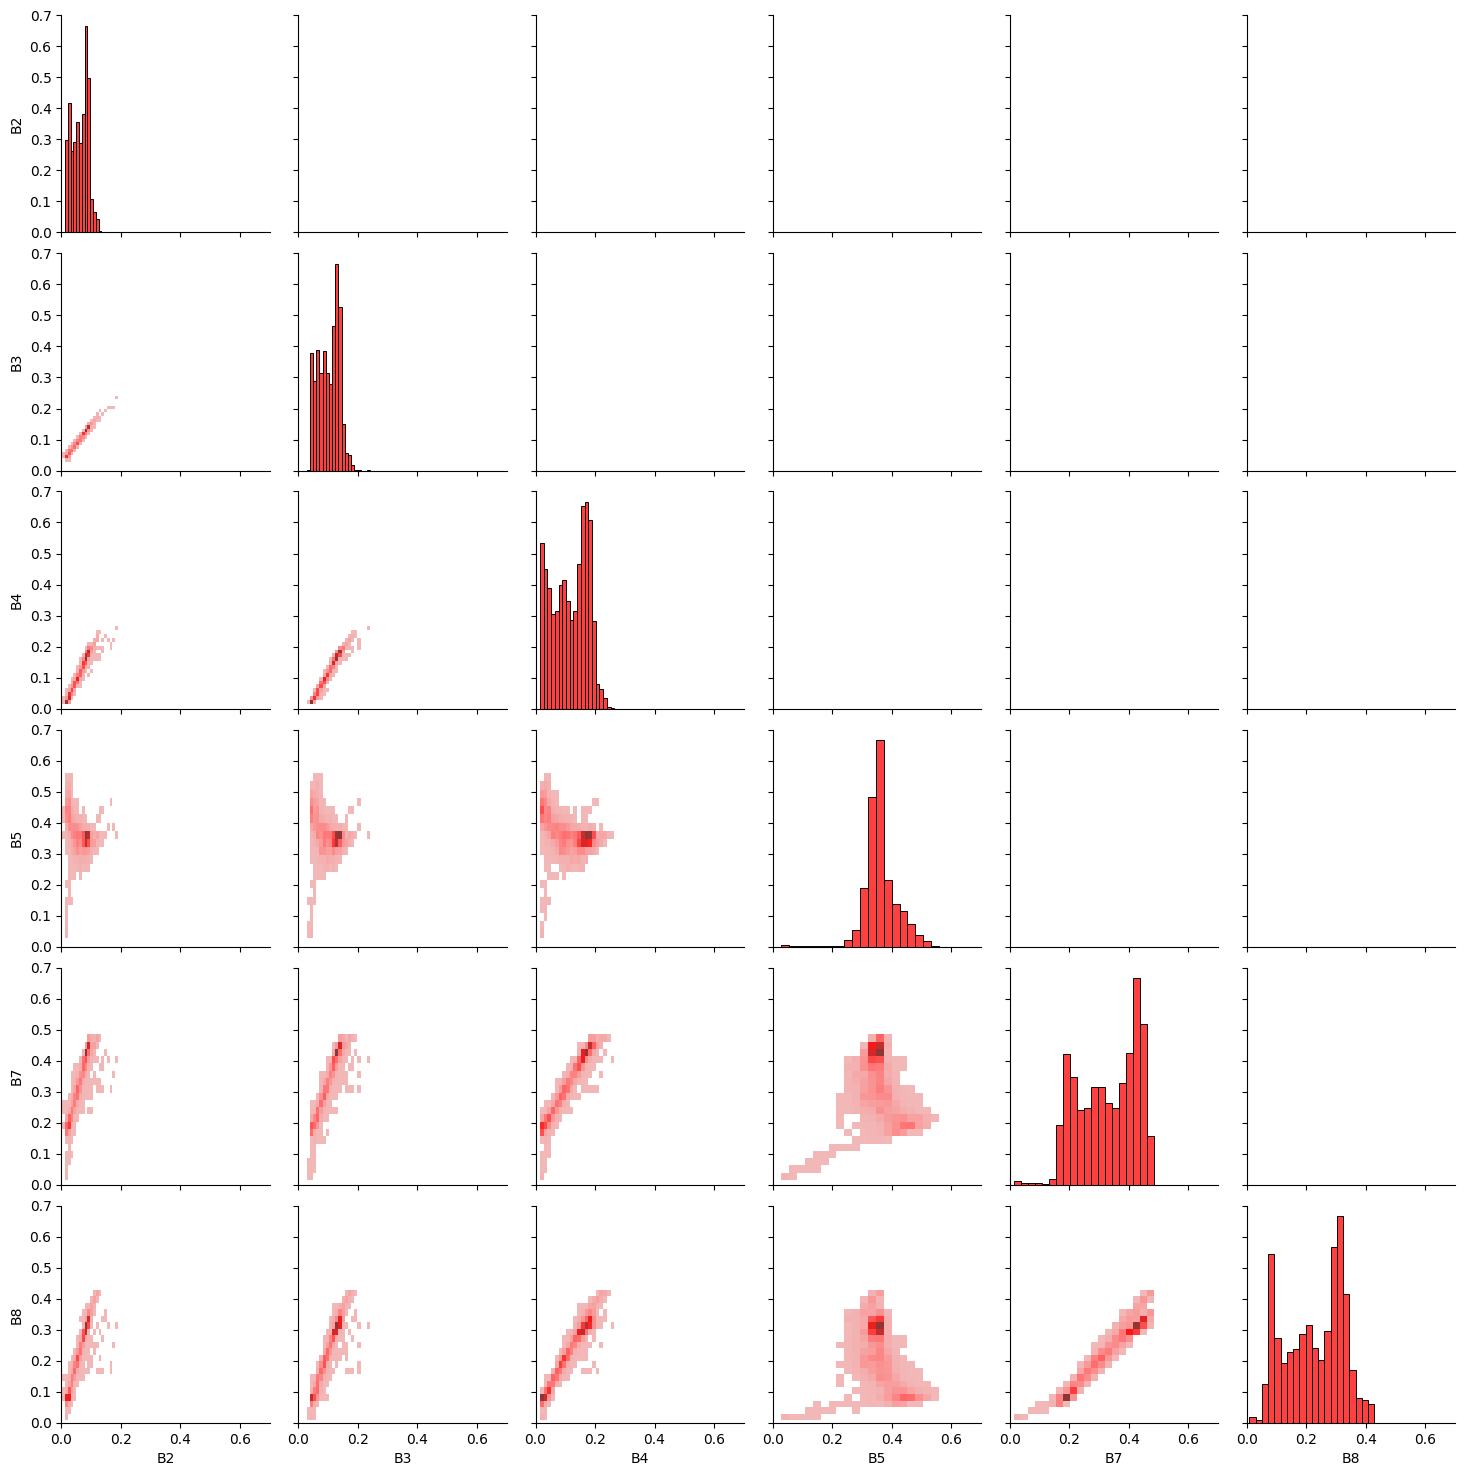

/workspace/data/lchu/hls/vis/zero_shot_visualization/B4_B5_Graph.png


<Figure size 640x480 with 0 Axes>

In [14]:
non_cloud_data = pd.DataFrame({
    'B2': non_cloud[0,0,1,:,:].flatten(),
    'B3': non_cloud[0,1,1,:,:].flatten(),
    'B4': non_cloud[0,2,1,:,:].flatten(),
    'B5': non_cloud[0,3,1,:,:].flatten(),
    'B7': non_cloud[0,4,1,:,:].flatten(),
    'B8': non_cloud[0,5,1,:,:].flatten()
})
gen_data = pd.DataFrame({
    'B2': predicted_masked[0,0,1,:,:].flatten(),
    'B3': predicted_masked[0,1,1,:,:].flatten(),
    'B4': predicted_masked[0,2,1,:,:].flatten(),
    'B5': predicted_masked[0,3,1,:,:].flatten(),
    'B7': predicted_masked[0,4,1,:,:].flatten(),
    'B8': predicted_masked[0,5,1,:,:].flatten()
})
true_data = pd.DataFrame({
    'B2': input_masked[0,0,1,:,:].flatten(),
    'B3': input_masked[0,1,1,:,:].flatten(),
    'B4': input_masked[0,2,1,:,:].flatten(),
    'B5': input_masked[0,3,1,:,:].flatten(),
    'B7': input_masked[0,4,1,:,:].flatten(),
    'B8': input_masked[0,5,1,:,:].flatten()
})
df = true_data[['B2','B3','B4','B5','B7','B8']]
g = sns.PairGrid(df, diag_sharey=False)

g.map_lower(sns.histplot, bins=20, color='red')
g.map_diag(sns.histplot, bins=20, color='red')

g.axes[0,0].set_xlim(0,0.7)
g.axes[0,0].set_ylim(0,0.7)
g.axes[1,1].set_xlim(0,0.7)
g.axes[1,1].set_ylim(0,0.7)
g.axes[2,2].set_xlim(0,0.7)
g.axes[2,2].set_ylim(0,0.7)
g.axes[3,3].set_xlim(0,0.7)
g.axes[3,3].set_ylim(0,0.7)
g.axes[4,4].set_xlim(0,0.7)
g.axes[4,4].set_ylim(0,0.7)
g.axes[5,5].set_xlim(0,0.7)
g.axes[5,5].set_ylim(0,0.7)

plt.show()

plt.tight_layout()
filename = 'B4_B5_Graph.png'
print(str(save_dir / filename))
plt.savefig(save_dir / filename, format='png')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

/workspace/data/lchu/hls/vis/zero_shot_visualization/B4_B5_Graph.png


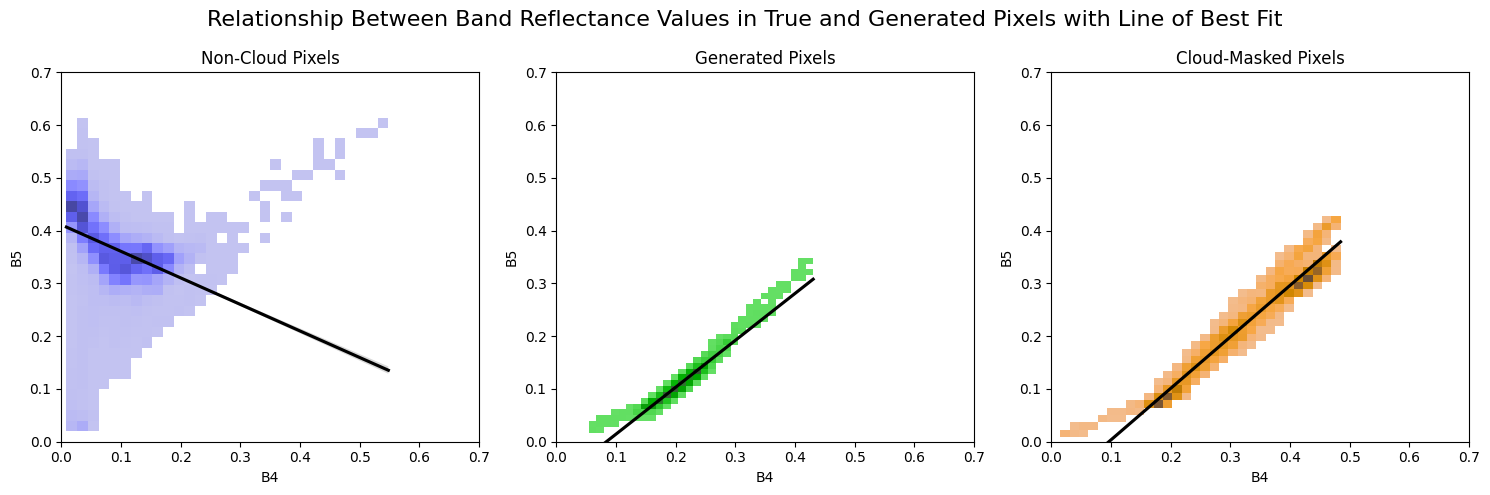

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(non_cloud_data, x="B4", y="B5", bins=30, ax=axes[0], color='blue')
axes[0].set_xlim(0, 0.7)
axes[0].set_ylim(0, 0.7)
axes[0].set_xlabel('Red Reflectance')
axes[0].set_ylabel('NIR Reflectance')
axes[0].set_title('Non-Cloud Pixels')
sns.regplot(non_cloud_data, x="B4", y="B5", ax=axes[0], scatter=False, color='black')

sns.histplot(gen_data, x="B4", y="B5", bins=30, ax=axes[1], color='green')
axes[1].set_xlim(0, 0.7)
axes[1].set_ylim(0, 0.7)
axes[1].set_xlabel('Red Reflectance')
axes[1].set_ylabel('NIR Reflectance')
axes[1].set_title('Generated Pixels')
sns.regplot(gen_data, x="B4", y="B5", ax=axes[1], scatter=False, color='black')

sns.histplot(true_data, x="B4", y="B5", bins=30, ax=axes[2], color='orange')
axes[2].set_xlim(0, 0.7)
axes[2].set_ylim(0, 0.7)
axes[2].set_xlabel('Red Reflectance')
axes[2].set_ylabel('NIR Reflectance')
axes[2].set_title('Cloud-Masked Pixels')
sns.regplot(true_data, x="B4", y="B5", ax=axes[2], scatter=False, color='black')

# Set a common title for all subplots
plt.suptitle(f'Relationship Between Band Reflectance Values in True and Generated Pixels with Line of Best Fit', fontsize=16)

# Adjust layout for better spacing between subplots
plt.tight_layout()
filename = 'B4_B5_Graph.png'
print(str(save_dir / filename))
plt.savefig(save_dir / filename, format='png')
